In [26]:
import math
import random

import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plotting the EfficientKAN activations
EfficientKAN lacks several utilities that PyKAN has. 

In this notebook we want to provide a basic implementation of the `.plot()` function for the EfficientKAN networks. This is useful for interpretation purposes.

---
## Generate the datasetSinX
Our first data set is quite simple. The following univariate function is selected:
$$f(x)=sin(8x)$$

In [131]:
def generate_dataset(num_samples):
    x = np.random.uniform(-1, 1, num_samples)
    return np.column_stack(x), np.sin(8 * x)


train_set = generate_dataset(num_samples=20000)
test_set = generate_dataset(num_samples=5000)
datasetSinX = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}

## EfficientKAN
The EfficientKAN network is first defined and then trained to near machine accuracy.

In [87]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200, shape=None):
        super(Efficient_KAN, self).__init__()
        if shape is None:
            shape = [1, 1]
        self.layers = shape
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            scale_base=0,
                            sp_trainable=False,
                            sb_trainable=False,
                            ).to(device)
        self.double()

    def forward(self, x, insight=False):
        return self.model.forward_insight(x) if insight else self.model(x)

In [5]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [6]:
def test(model, inputs, labels, batch_size=100):
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                output = model(x).cpu()
                output = output.squeeze()
                losses.append(criterion(output, y.double()))
    return (sum(losses) / len(losses)).item()

In [132]:
modelSinX = Efficient_KAN(grid_size=50, shape=[1, 1])

In [134]:
train(modelSinX, optim.Adam(modelSinX.parameters(), lr=0.025), datasetSinX["train_input"].view(-1, 1),
      datasetSinX["train_label"],
      epochs=200,
      batch_size=10000)

100%|██████████| 2/2 [00:00<00:00, 68.72it/s, loss=5.03e-11, lr=0.0205]


In [135]:
test(modelSinX, datasetSinX["test_input"].view(-1, 1), datasetSinX["test_label"])

100%|██████████| 50/50 [00:00<00:00, 1476.92it/s]


4.894132296093589e-11

## The plot() function
The `plot()` function gives us an idea of what KAN understood the domain problem to be.

In [257]:
def plot_spline(model: EffKAN, x_range, scale=1, resolution=50):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = torch.linspace(x_range[0], x_range[1], resolution)
                # expanded_x_vals = torch.cat((x_vals, torch.zeros(resolution * (layer.in_features - 1))))
                # y_vals = F.linear(
                #     layer.b_splines(expanded_x_vals.view(-1, layer.in_features)),
                #     layer.scaled_spline_weight.view(layer.in_features * layer.out_features, -1),
                # ).view(-1).detach()[:resolution]
                # y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                # B-Splines
                grid = layer.grid[j, :].unsqueeze(0)  # The knots
                x = x_vals.unsqueeze(-1).unsqueeze(-1)
                bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
                for k in range(1, layer.spline_order + 1):
                    bases = (
                                    (x - grid[:, : -(k + 1)])
                                    / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                    * bases[:, :, :-1]
                            ) + (
                                    (grid[:, k + 1:] - x)
                                    / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                    * bases[:, :, 1:]
                            )

                y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i]).detach()
                y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                alpha = math.tanh(abs(3 * layer.spline_scaler.view(layer.out_features, -1)[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals, y_vals, alpha=alpha, color=colors[i])
                    axes[i * layer.out_features + j].grid(True)
                else:
                    axes.plot(x_vals, y_vals, alpha=alpha, color=colors[i])
                    axes.grid(True)

    # plt.tight_layout()
    plt.show()

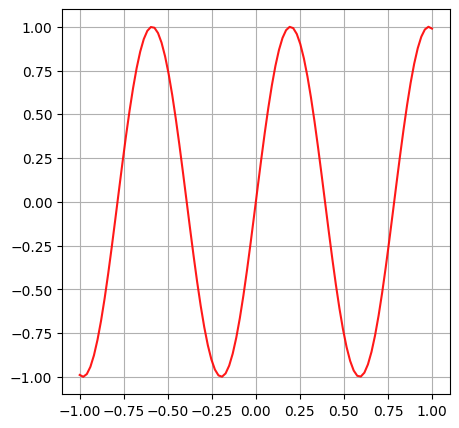

In [258]:
plot_spline(modelSinX.model, [-1, 1], scale=2.5, resolution=100)

## Verify plot correctness
The network is queried with a uniform domain distribution to prove that the previous graph was correct.

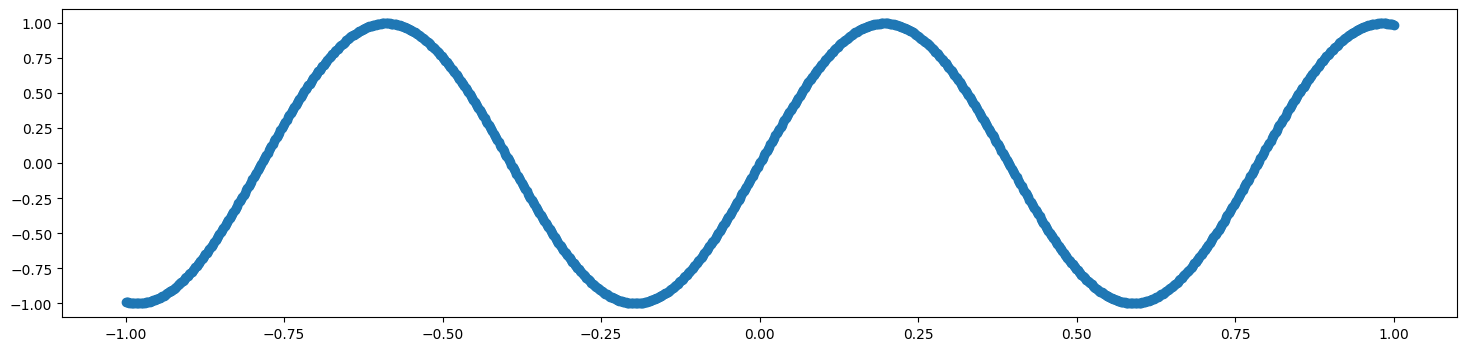

In [103]:
x_axis = torch.linspace(-1, 1, steps=1000)
y_axis = modelSinX(x_axis.view(-1, 1)).detach().numpy()
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()


---
## Generate the datasetSinX
Next, we will attempt to reproduce the multiplication experiment described in the original paper.
$$f(x,y)=x\cdot y$$

In [111]:
def generate_dataset(num_samples=1000, noise_std=1e-12):
    x, y = np.random.uniform(-1, 1, num_samples), np.random.uniform(-1, 1, num_samples)
    noise = np.random.normal(0, noise_std, num_samples)
    return np.column_stack((x, y)), x * y + noise


train_set = generate_dataset(num_samples=10000, noise_std=0)
test_set = generate_dataset(num_samples=5000, noise_std=0)
datasetXY = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}

In [113]:
modelXY = Efficient_KAN(grid_size=5, shape=[2, 2, 1])

In [269]:
train(modelXY, optim.Adam(modelXY.parameters(), lr=0.00025), datasetXY["train_input"],
      datasetXY["train_label"],
      epochs=200,
      batch_size=10000)

100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=5.16e-7, lr=0.000205]


In [270]:
test(modelXY, datasetXY["test_input"], datasetXY["test_label"])

100%|██████████| 50/50 [00:00<00:00, 892.34it/s]


6.337352495459084e-07

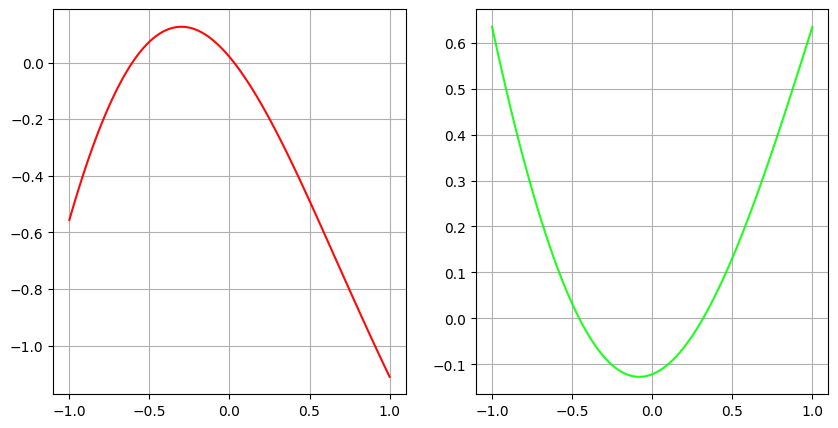

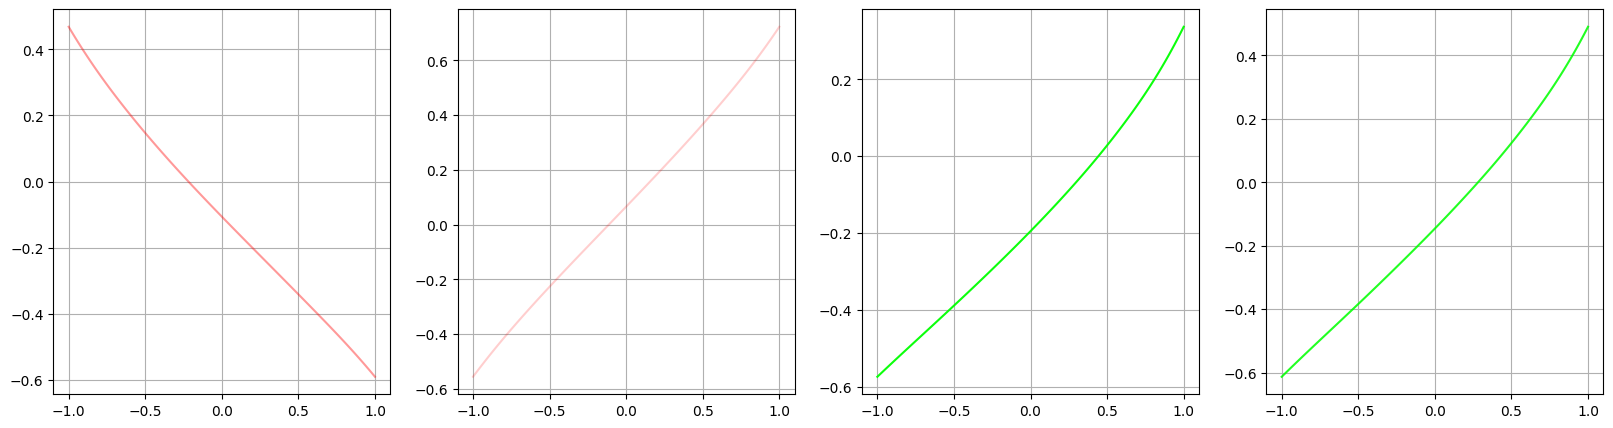

In [271]:
plot_spline(modelXY.model, [-1, 1], scale=2.5, resolution=100)

In [ ]:
scale = 2
x_range = [-1, 1]
resolution = 50
k = 3
for layer in reversed(modelXY.layers):
    fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                             figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))

    for i in range(layer.in_features):
        for j in range(layer.out_features):
            x_vals = torch.linspace(x_range[0], x_range[1], resolution)

            # B-Splines
            grid = layer.grid[j, :].unsqueeze(0)  # The knots
            bases = ((x_vals >= grid[:, :-1]) & (x_vals < grid[:, 1:])).to(
                x_vals.dtype)  # Determine the interval for each point
            for k in range(1, k + 1):
                bases = (
                                (x_vals - grid[:, : -(k + 1)])
                                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                * bases[:, :, :-1]
                        ) + (
                                (grid[:, k + 1:] - x_vals)
                                / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                * bases[:, :, 1:]
                        )

            y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i])
            y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

            if type(axes) is np.ndarray:
                axes[i * layer.out_features + j].plot(x_vals, y_vals)
            else:
                axes.plot(x_vals, y_vals)

# plt.tight_layout()
plt.show()


## Last try
Next, we check that the plotting function also works with wider layers
$$f(x,y)=sin(8x)+cos(4y)$$

In [329]:
def generate_dataset(num_samples=1000, noise_std=1e-12):
    x, y = np.random.uniform(-1, 1, num_samples), np.random.uniform(-1, 1, num_samples)
    return np.column_stack((x, y)), np.sin(8 * x) + np.cos(4 * y)


train_set = generate_dataset(num_samples=10000, noise_std=0)
test_set = generate_dataset(num_samples=5000, noise_std=0)
datasetSinXCosY = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}

In [337]:
modelSinXCosY = Efficient_KAN(grid_size=10, shape=[2, 1])

In [339]:
train(modelSinXCosY, optim.Adam(modelSinXCosY.parameters(), lr=0.025), datasetSinXCosY["train_input"],
      datasetSinXCosY["train_label"],
      epochs=100,
      batch_size=10000)

100%|██████████| 1/1 [00:00<00:00, 100.01it/s, loss=9.36e-5, lr=0.0226]


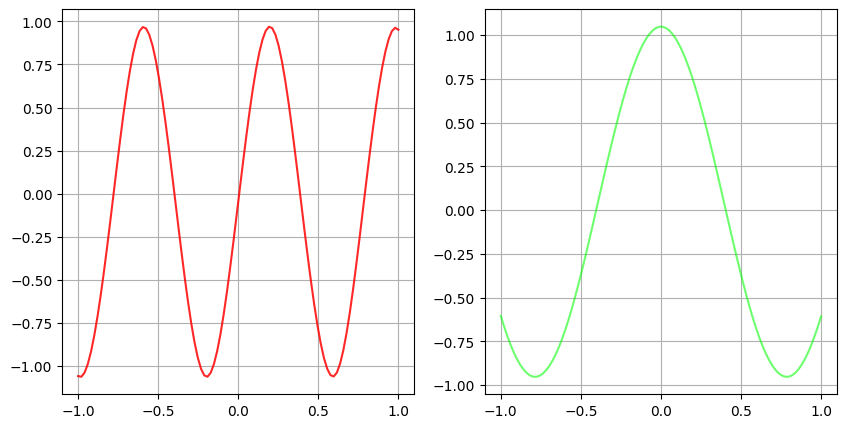

In [340]:
plot_spline(modelSinXCosY.model, [-1, 1], scale=2.5, resolution=100)